# Préparation du dataset

## Import des modules

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime as dt
import itertools

## Ouverture des CSV

In [28]:
df_00 = pd.read_csv('datasets/F1-00.csv')
df_01 = pd.read_csv('datasets/F1-01.csv')
#df_02 = pd.read_csv('datasets/F1-02.csv')
#df_03 = pd.read_csv('datasets/F1-03.csv')
df_04 = pd.read_csv('datasets/F1-04.csv')
df_05 = pd.read_csv('datasets/F1-05.csv')
df_06 = pd.read_csv('datasets/F1-06.csv')
df_07 = pd.read_csv('datasets/F1-07.csv')
df_08 = pd.read_csv('datasets/F1-08.csv')
df_09 = pd.read_csv('datasets/F1-09.csv')
df_10 = pd.read_csv('datasets/F1-10.csv')
df_11 = pd.read_csv('datasets/F1-11.csv')
df_12 = pd.read_csv('datasets/F1-12.csv')
df_13 = pd.read_csv('datasets/F1-13.csv')
df_14 = pd.read_csv('datasets/F1-14.csv')
df_15 = pd.read_csv('datasets/F1-15.csv')
df_16 = pd.read_csv('datasets/F1-16.csv')
df_17 = pd.read_csv('datasets/F1-17.csv')
df_18 = pd.read_csv('datasets/F1-18.csv')
df_19 = pd.read_csv('datasets/F1-19.csv')
df_20 = pd.read_csv('datasets/F1-20.csv')
df_21 = pd.read_csv('datasets/F1-21.csv')


In [29]:
# On retire les lignes buggées
df_13 = df_13.drop(df_13.index[-1])
df_15 = df_15.drop(df_15.index[-1])
# On retire la dernière journée de la saison covid qui est incomplète
# (C'est con Rennes avait gagné 5-0 contre Montpellier)
df_19 = df_19.drop(df_19.tail(9).index)

In [30]:
col = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR','WHH','WHD','WHA']

df_00 = df_00[col]
df_01 = df_01[col]
#df_02 = df_02[col]
#df_03 = df_03[col]
df_04 = df_04[col]
df_05 = df_05[col]
df_06 = df_06[col]
df_07 = df_07[col]
df_08 = df_08[col]
df_09 = df_09[col]
df_10 = df_10[col]
df_11 = df_11[col]
df_12 = df_12[col]
df_13 = df_13[col]
df_14 = df_14[col]
df_15 = df_15[col]
df_16 = df_16[col]
df_17 = df_17[col]
df_18 = df_18[col]
df_19 = df_19[col]
df_20 = df_20[col]
df_21 = df_21[col]

## Ajout des buts marqués et encaissés

In [31]:
# Fonction renvoyant un dataframe du cumul de buts marqués par journée, par équipe
def scored(df, covid):
    # Création du sictionnaire des équipes de la saison
    teams = {}
    for i in df['HomeTeam'].unique():
        teams[i] = []
    # Journée par journée, on ajoute le nombre de buts marqués
    for __, row in df.iterrows():
        goal_home = row['FTHG']
        goal_away = row['FTAG']
        teams[row['HomeTeam']].append(goal_home)
        teams[row['AwayTeam']].append(goal_away)
    # On ajoute ces données dans un dataframe équipe par équipe, journée par journée
    colonnes = list(range(1, 2*(len(teams)-1)+1))
    if covid:
        colonnes = list(range(1, 28))
    df_scored = pd.DataFrame(data = teams, index=colonnes).T
    df_scored.insert(0, 0, 0)
    # On cumule le nombre de buts marqués
    for i in colonnes:
        df_scored[i] = df_scored[i] + df_scored[i-1]
    return df_scored
    

In [32]:
# Fonction renvoyant un dataframe du cumul de buts encaissés par journée, par équipe
def conceded(df, covid):
    # Création du dictionnaire des équipes de la saison
    teams = {}
    for i in df['HomeTeam'].unique():
        teams[i] = []
    # Journée par journée, on ajoute le nombre de buts encaissés
    for __, row in df.iterrows():
        goal_home = row['FTHG']
        goal_away = row['FTAG']
        teams[row['HomeTeam']].append(goal_away)
        teams[row['AwayTeam']].append(goal_home)
    # On ajoute ces données dans un dataframe équipe par équipe, journée par journée
    colonnes = list(range(1, 2*(len(teams)-1)+1))
    if covid:
        colonnes = list(range(1, 28))
    df_conc = pd.DataFrame(data = teams, index=colonnes).T
    df_conc.insert(0, 0, 0)
    # On cumule le nombre de buts encaissés
    for i in colonnes:
        df_conc[i] = df_conc[i] + df_conc[i-1]
    return df_conc

In [33]:
# Fonction ajoutant les buts marqués et encaissés par chaque équipe chaque journée
def get_goals(df, covid):
    # On récupère les dataframes de buts marqués et encaissés par journée
    goal_sc = scored(df, covid)
    goal_co = conceded(df, covid)
    
    # On calcule le nombre de matches par journée
    matches_per_day = int(len(df)/(goal_sc.shape[1]-1))

    # On initialise les tableaux
    day = 0
    M_week = []
    H_scored = []
    H_conceded = []
    A_scored = []
    A_conceded = []

    # Pour chaque match, on ajoute les buts
    for index, row in df.iterrows():
        M_week.append(day+1)
        H_scored.append(goal_sc[day][row['HomeTeam']])
        H_conceded.append(goal_co[day][row['HomeTeam']])
        A_scored.append(goal_sc[day][row['AwayTeam']])
        A_conceded.append(goal_co[day][row['AwayTeam']])
        # On incrémente day quand on passe d'une journée à une autre
        if ((index + 1)% matches_per_day) == 0:
            day += 1
    
    df['MatchWeek'] = M_week
    df['HomeScored'] = H_scored
    df['HomeConceded'] = H_conceded
    df['AwayScored'] = A_scored
    df['AwayConceded'] = A_conceded

    return df


In [34]:
df_00 = get_goals(df_00, False)
df_01 = get_goals(df_01, False)
#df_02 = get_goals(df_02, False)
#df_03 = get_goals(df_03, False)
df_04 = get_goals(df_04, False)
df_05 = get_goals(df_05, False)
df_06 = get_goals(df_06, False)
df_07 = get_goals(df_07, False)
df_08 = get_goals(df_08, False)
df_09 = get_goals(df_09, False)
df_10 = get_goals(df_10, False)
df_11 = get_goals(df_11, False)
df_12 = get_goals(df_12, False)
df_13 = get_goals(df_13, False)
df_14 = get_goals(df_14, False)
df_15 = get_goals(df_15, False)
df_16 = get_goals(df_16, False)
df_17 = get_goals(df_17, False)
df_18 = get_goals(df_18, False)
df_19 = get_goals(df_19, True)
df_20 = get_goals(df_20, False)
df_21 = get_goals(df_21, False)

## Ajout des points

In [35]:
# Création d'un dataframe de résultats des équipes par journée
def result(df, covid):
    # Création du dictionnaire des équipes de la saison
    teams = {}
    for i in df['HomeTeam'].unique():
        teams[i] = []
    # Remplissage du ditionnaire (W:Victoire, L:Défaite, D:Match nul)
    for index, row in df.iterrows():
        if row['FTR'] == 'H':
            teams[row['HomeTeam']].append('W')
            teams[row['AwayTeam']].append('L')
        if row['FTR'] == 'D':
            teams[row['HomeTeam']].append('D')
            teams[row['AwayTeam']].append('D')
        if row['FTR'] == 'A':
            teams[row['HomeTeam']].append('L')
            teams[row['AwayTeam']].append('W')
    
    colonnes = list(range(1, 2*(len(teams)-1)+1))
    if covid:
        colonnes = list(range(1, 28))
    # Création du dataframe
    return pd.DataFrame(data=teams, index = colonnes).T

In [36]:
# Fonction transformant un résultat en points
def points(string):
    if string == 'W':
        return 3
    if string == 'D':
        return 1
    if string == 'L':
        return 0
    else:
        return 0

In [37]:
# Création d'un dataframe des points cumulés par journée
def result_pts(results):
    # On transforme les résultats en points
    results = results.applymap(points)
    
    # On cumule le nombre de points
    for i in range(2,results.shape[1]+1):
        results[i] = results[i] + results[i-1]
    results.insert(0, 0, 0)

    return results

In [38]:
# Ajout des points par journée au dataframe
def get_points(df, covid):
    res = result(df, covid)
    res = result_pts(res)

    # On initialise les tableaux
    day = 0
    H_pts = []
    A_pts = []
    
    # On calcule le nombre de matches par journée
    matches_per_day = int(len(df)/(res.shape[1]-1))

    # Pour chaque match, on ajoute les points
    for index, row in df.iterrows():
        H_pts.append(res[day][row['HomeTeam']])
        A_pts.append(res[day][row['AwayTeam']])
        # On incrémente day quand on passe d'une journée à une autre
        if ((index + 1)% matches_per_day) == 0:
            day += 1
    
    df['HomePoints'] = H_pts
    df['AwayPoints'] = A_pts

    return df

In [39]:
df_00 = get_points(df_00, False)
df_01 = get_points(df_01, False)
#df_02 = get_points(df_02, False)
#df_03 = get_points(df_03, False)
df_04 = get_points(df_04, False)
df_05 = get_points(df_05, False)
df_06 = get_points(df_06, False)
df_07 = get_points(df_07, False)
df_08 = get_points(df_08, False)
df_09 = get_points(df_09, False)
df_10 = get_points(df_10, False)
df_11 = get_points(df_11, False)
df_12 = get_points(df_12, False)
df_13 = get_points(df_13, False)
df_14 = get_points(df_14, False)
df_15 = get_points(df_15, False)
df_16 = get_points(df_16, False)
df_17 = get_points(df_17, False)
df_18 = get_points(df_18, False)
df_19 = get_points(df_19, True)
df_20 = get_points(df_20, False)
df_21 = get_points(df_21, False)

## Ajout de la forme de l'équipe

In [40]:
# Fontion renvoyant un tableau contenant les 'num' résultats récents de chaque équipe par journée
def form(df, num, covid):
    res = result(df, covid)
    new_res = res.copy()
    # On ajoute les résultats récents
    for i in range(num, res.shape[1]+1):
        new_res[i] = ''
        j = 0
        while j < num:
            new_res[i] += res[i-j]
            j += 1
    return new_res

In [41]:
# Ajout des 'num' derniers résultats récents par journée au dataframe
def num_form(df, num, covid):
    forme = form(df, num, covid)
    # Création de listes de séries
    # Les premiers matchs, ou on ne peut pas avoir de série, sont marqués 'X'
    home = ['X' for i in range(num*int(len(forme)/2))]
    away = ['X' for i in range(num*int(len(forme)/2))]

    matches_per_day = int(len(df)/(forme.shape[1]-1))

    day = num
    #for i in range(num*int(len(forme)/2), len(df)):
    for index, row in df.iterrows():
        if index >= num*int(len(forme)/2):
            home_form = forme[day][row['HomeTeam']]
            away_form = forme[day][row['AwayTeam']]
            # On ajoute le 'num' dernier résultat
            home.append(home_form[num-1])
            away.append(away_form[num-1])
            # On incrémente day quand on passe d'une journée à une autre
            if ((index + 1)% matches_per_day) == 0:
                day += 1
    
    # On ajoute la série au dataframe
    df['HS'+str(num)] = home
    df['AS'+str(num)] = away

    return df

In [42]:
# Ajout des derniers résultats récents par journée au dataframe
def get_form(df, covid):
    for i in range(1,6):
        df = num_form(df, i, covid)
    return df

In [43]:
df_00 = get_form(df_00, False)
df_01 = get_form(df_01, False)
#df_02 = get_form(df_02, False)
#df_03 = get_form(df_03, False)
df_04 = get_form(df_04, False)
df_05 = get_form(df_05, False)
df_06 = get_form(df_06, False)
df_07 = get_form(df_07, False)
df_08 = get_form(df_08, False)
df_09 = get_form(df_09, False)
df_10 = get_form(df_10, False)
df_11 = get_form(df_11, False)
df_12 = get_form(df_12, False)
df_13 = get_form(df_13, False)
df_14 = get_form(df_14, False)
df_15 = get_form(df_15, False)
df_16 = get_form(df_16, False)
df_17 = get_form(df_17, False)
df_18 = get_form(df_18, False)
df_19 = get_form(df_19, True)
df_20 = get_form(df_20, False)
df_21 = get_form(df_21, False)

In [44]:
# On combine les différentes saisons
df = pd.concat([df_00,
                df_01,
                #df_02,
                #df_03,
                df_04,
                df_05,
                df_06,
                df_07,
                df_08,
                df_09,
                df_10,
                df_11,
                df_12,
                df_13,
                df_14,
                df_15,
                df_16,
                df_17,
                df_18,
                df_19,
                df_20,
                df_21], ignore_index=True)

In [45]:
def points_streak(string):
    sum = 0
    for letter in string:
        sum += points(letter)
    return sum

In [46]:
df['HomeFormPtsStr'] = df['HS1'] + df['HS2'] + df['HS3'] + df['HS4'] + df['HS5']
df['AwayFormPtsStr'] = df['AS1'] + df['AS2'] + df['AS3'] + df['AS4'] + df['AS5']

df['HomeFormPts'] = df['HomeFormPtsStr'].apply(points_streak)
df['AwayFormPts'] = df['AwayFormPtsStr'].apply(points_streak)

In [47]:
# Fonctions afin de vérifier s'il y a eu une série de victoires ou de défaites
def get_3GW(string):
    if string[-3:] == 'WWW':
        return 1
    else:
        return 0

def get_5GW(string):
    if string == 'WWWWW':
        return 1
    else:
        return 0

def get_3GL(string):
    if string[-3:] == 'LLL':
        return 1
    else:
        return 0

def get_5GL(string):
    if string == 'LLLLL':
        return 1
    else:
        return 0

In [48]:
df['Home3GW'] = df['HomeFormPtsStr'].apply(get_3GW)
df['Home5GW'] = df['HomeFormPtsStr'].apply(get_5GW)
df['Home3GL'] = df['HomeFormPtsStr'].apply(get_3GL)
df['Home5GL'] = df['HomeFormPtsStr'].apply(get_5GL)

df['Away3GW'] = df['AwayFormPtsStr'].apply(get_3GW)
df['Away5GW'] = df['AwayFormPtsStr'].apply(get_5GW)
df['Away3GL'] = df['AwayFormPtsStr'].apply(get_3GL)
df['Away5GL'] = df['AwayFormPtsStr'].apply(get_5GL)

## Dataset Final

In [49]:
col = ['HomeTeam','AwayTeam','FTR','MatchWeek','HomeScored','HomeConceded','AwayScored','AwayConceded','HomePoints','AwayPoints',
       'WHH','WHD','WHA',
       'HomeFormPtsStr','AwayFormPtsStr','HomeFormPts','AwayFormPts',
       'Home3GW','Home5GW','Home3GL','Home5GL',
       'Away3GW','Away5GW','Away3GL','Away5GL',]

df = df[col]

In [50]:
df.to_csv('dataset.csv',index=False)

### Correlation Matrix

/var/folders/bg/vbvjjnmj0hv9wmb92ngxcq9m0000gn/T/ipykernel_5696/3367888214.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot= True)


<AxesSubplot: >

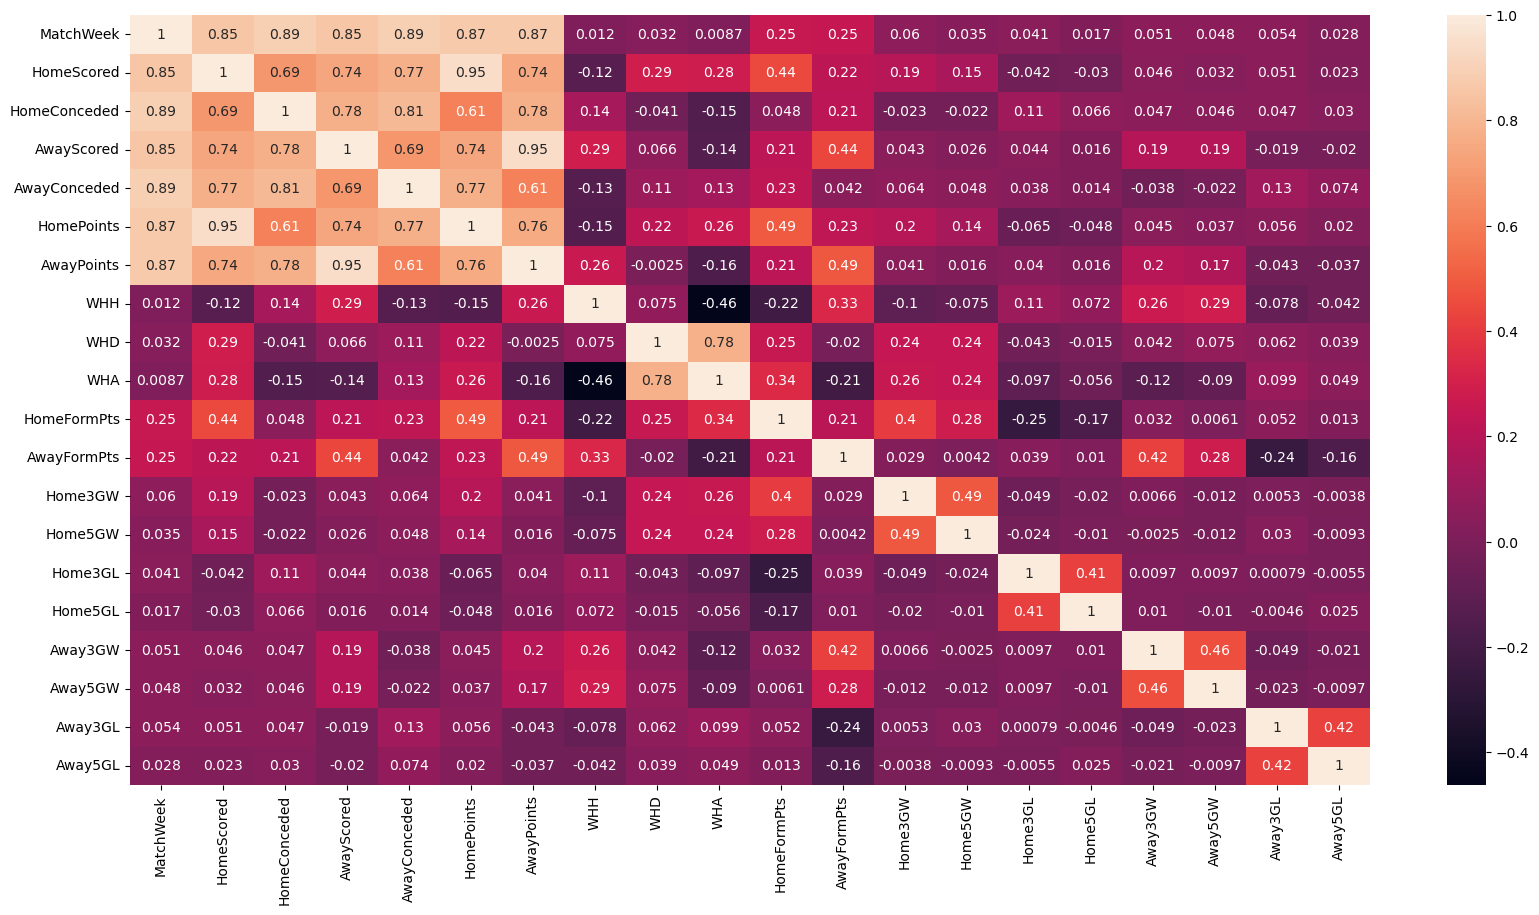

In [51]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), annot= True)

Explications trouvées en ligne :

POSITIVE CORRELATION: If an increase in feature A leads to increase in feature B, then they are positively correlated. A value 1 means perfect positive correlation.

NEGATIVE CORRELATION: If an increase in feature A leads to decrease in feature B, then they are negatively correlated. A value -1 means perfect negative correlation.

Now lets say that two features are highly or perfectly correlated, so the increase in one leads to increase in the other. This means that both the features are containing highly similar information and there is very little or no variance in information. This is known as MultiColinearity as both of them contains almost the same information.

So do you think we should use both of them as one of them is redundant. While making or training models, we should try to eliminate redundant features as it reduces training time and many such advantages.

Visualiser le dataset :

array([[<AxesSubplot: xlabel='MatchWeek', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='HomeScored', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='HomeConceded', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='AwayScored', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='AwayConceded', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='HomePoints', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='AwayPoints', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='WHH', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='WHD', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='WHA', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='HomeFormPts', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='AwayFormPts', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='Home3GW', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='Home5GW', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='Home3GL', ylabel='MatchWeek'>,
        <AxesSubplot: xlabel='Home5GL', ylabel='MatchWeek'>,
    

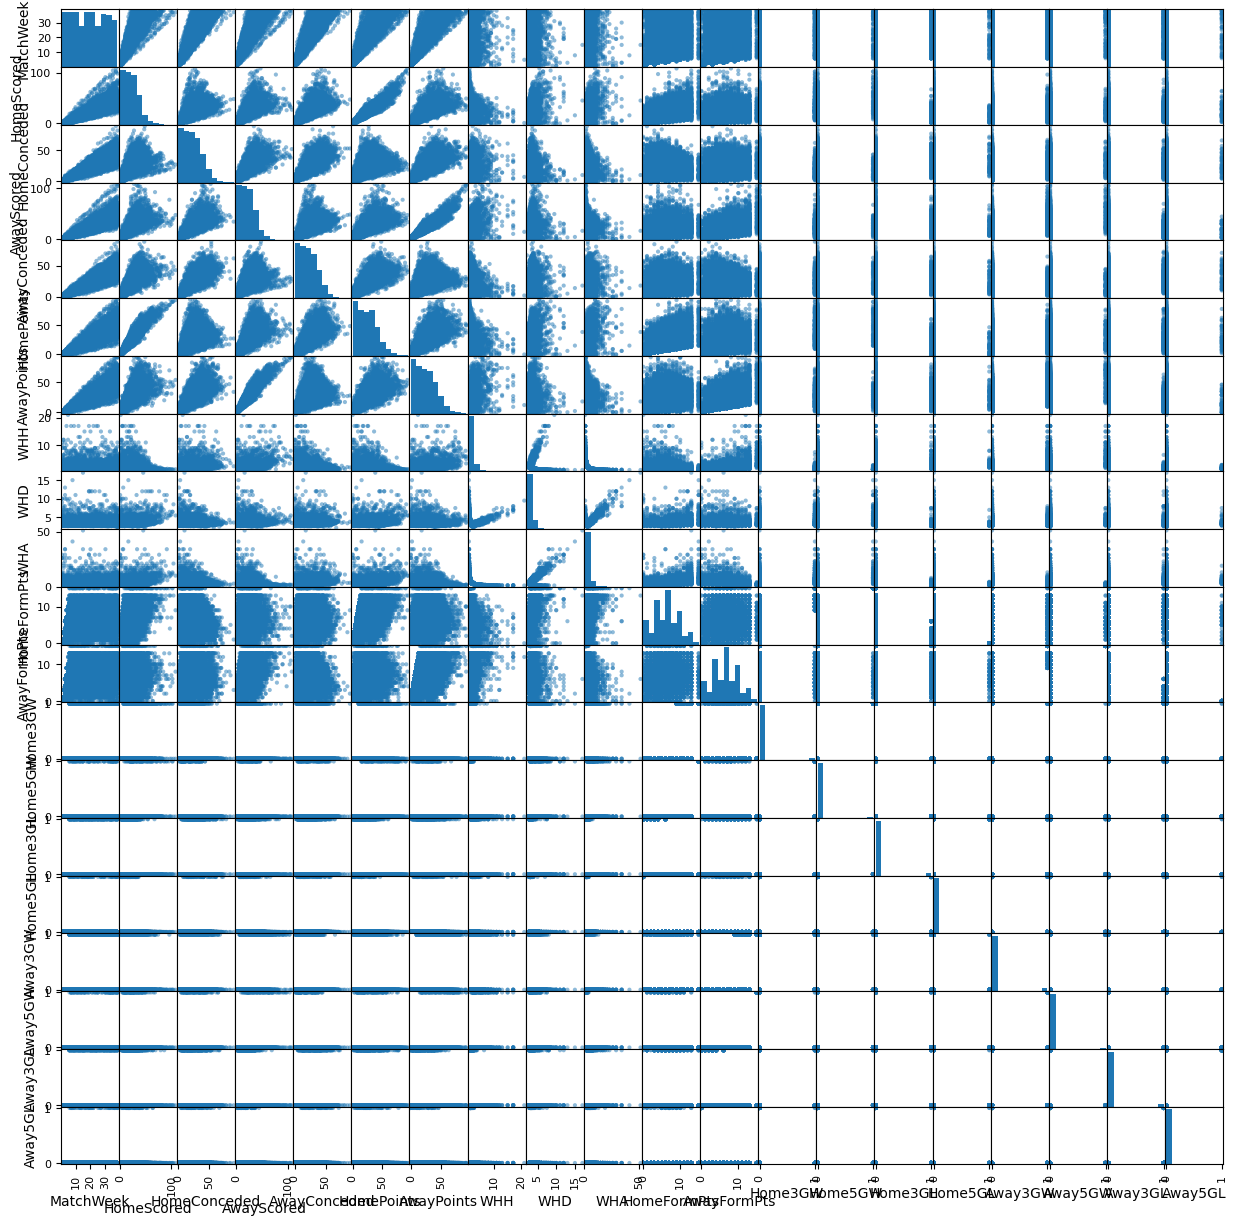

In [53]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, figsize=(15,15))

## XGBoost

In [ ]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier(seed=82)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=82,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Predicting the Test set results
Y_pred = classifier.predict(X_test)

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, Y_pred)

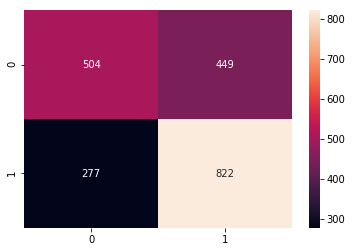

In [ ]:
sns.heatmap(cm, annot=True,fmt='d')

In [ ]:
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           H       0.65      0.53      0.58       953
          NH       0.65      0.75      0.69      1099

    accuracy                           0.65      2052
   macro avg       0.65      0.64      0.64      2052
weighted avg       0.65      0.65      0.64      2052



**Clearly XGBoost seems like the best model as it has the highest F1 score and accuracy score on the test set.**

### Tuning the parameters of XGBoost.

In [ ]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import xgboost as xgb

# TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''

    y_pred = clf.predict(features)
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print(clf)

# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print( "F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=2,
              silent=None, subsample=0.8, verbosity=1)
F1 score and accuracy score for training set: 0.6038 , 0.6667.
F1 score and accuracy score for test set: 0.5779 , 0.6477.


#### Probably little best!!!!!!!!

Accuracy is not soo good but it can improved.

Actually it only depend upon past year match dataset,we can improve the accuracy by putting twitter data related to match, sentiment analysis, chances of player to play a specific match,player performace in recent series,etc..

I hope you find this kernel useful and enjoyable. If so please upVote

Your comments and feedback are most welcome.